# 02 — Preprocessing & Training

<div style="border:2px solid #FF9800; border-radius:10px; padding:16px; background:#fff8f0">

<h3>⚖️ Probability Modeling & Class Imbalance (Notebook 2)</h3>

**Target Distribution**  
- ~84% **No Attrition**  
- ~16% **Yes Attrition**  
This imbalance is important to acknowledge, but we are not building a binary classifier.  
Our objective is to **estimate calibrated probabilities of attrition (risk scores)** for each employee.

**Why This Matters**  
- If a model is trained naively, predicted probabilities may be biased downward (e.g., rarely exceeding 0.20), underestimating true risk.  
- Instead of accuracy, we focus on **probability-quality metrics**:
  - **ROC-AUC:** How well the probabilities rank high-risk vs low-risk employees.  
  - **Log Loss / Brier Score:** Whether predicted risks match observed frequencies.  
  - **Calibration Curves:** Ensuring, for example, that a predicted 0.30 risk ≈ 30% actual attrition.  

**Modeling Adjustments**  
- Use algorithms that support **class weighting** (`class_weight="balanced"` in Logistic Regression, Decision Trees, Random Forests, Gradient Boosting).  
- Preserve the true class distribution (no aggressive oversampling/undersampling) to maintain realistic probabilities.  
- Emphasize probability calibration over threshold-based metrics (like F1).

**Takeaway**  
We are shifting from a "Yes/No attrition prediction" to a **risk scoring framework**.  
This provides business stakeholders with flexible thresholds (e.g., intervene if risk > 0.25) rather than a rigid classification.

</div>



### <div class="alert alert-info" align = center> Imports</div>

In [43]:
import os, sys, warnings, subprocess, json, hashlib, shutil, glob, pathlib, time, joblib, datetime
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, brier_score_loss, log_loss
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



# Settings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
plt.style.use("seaborn-v0_8")   # clean default style
sns.set_palette("muted")        # consistent colors

#Start a timer to check the execution time of the notebook.
start_time = time.time()

### <div class="alert alert-info" > Load The Data</div>

In [3]:
# Define base path
datapath = "data"

emp_att = pd.read_csv(os.path.join(datapath, "employee_attrition.csv"))

In [5]:
emp_att.head().T

,0,1,2,3,4
Age,41,49,37,33,27
Attrition,Yes,No,Yes,No,No
BusinessTravel,Travel_Rarely,Travel_Frequently,Travel_Rarely,Travel_Frequently,Travel_Rarely
DailyRate,1102,279,1373,1392,591
Department,Sales,Research & Development,Research & Development,Research & Development,Research & Development
DistanceFromHome,1,8,2,3,2
Education,2,1,2,4,1
EducationField,Life Sciences,Life Sciences,Other,Life Sciences,Medical
EmployeeNumber,1,2,4,5,7
EnvironmentSatisfaction,2,3,4,4,1


In [6]:
emp_att.shape, emp_att['Attrition'].value_counts(normalize=True), emp_att.dtypes.value_counts()

((1470, 31),
 Attrition
 No     0.838776
 Yes    0.161224
 Name: proportion, dtype: float64,
 int64     23
 object     8
 Name: count, dtype: int64)

<div style="border:2px solid #009688; border-radius:10px; padding:16px; background:#f0fffc">

<h3>📏 Scaling Strategy — Based on EDA (Notebook 2)</h3>

Based on the distribution insights identified during wrangling and EDA, we will scale the data as follows:

| Strategy         | Features |
|------------------|----------|
| **RobustScaler** | MonthlyIncome, TotalWorkingYears, YearsAtCompany — right-skewed, wide ranges, sensitive to outliers |
| **StandardScaler** | Age, plus other moderate numeric features — approximately centered, moderate spread |
| **Passthrough (no scaling)** | All categorical features (BusinessTravel, Department, EducationField, Gender, JobRole, MaritalStatus, OverTime) will be handled via One-Hot Encoding instead of scaling |

**Notes**  
- RobustScaler mitigates the effect of skew and outliers for income and tenure features.  
- StandardScaler normalizes age and remaining numeric fields onto a comparable scale.  
- Categorical features will not be scaled; instead, we will use One-Hot Encoding to preserve categories.  
- Target (`Attrition`) is excluded from transformations; it will only be mapped to binary for probability modeling.

</div>


In [8]:
# Target
emp_att["Attrition_bin"] = emp_att["Attrition"].map({"No":0,"Yes":1})

X = emp_att.drop(columns=["Attrition","Attrition_bin"], errors="ignore")
y = emp_att["Attrition_bin"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature grouping based on EDA
cat_features = ["BusinessTravel","Department","EducationField",
                "Gender","JobRole","MaritalStatus","OverTime"]

robust_features = ["MonthlyIncome","TotalWorkingYears","YearsAtCompany"]  # skewed, wide ranges
standard_features = ["Age"]  # relatively centered, moderate spread

# any other numeric features not in above lists
other_num_features = [c for c in X.select_dtypes(include="number").columns
                      if c not in robust_features + standard_features]


In [10]:
# Preprocessing transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("robust", RobustScaler(), robust_features),
        ("standard", StandardScaler(), standard_features + other_num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
    ],
    remainder="drop"
)


In [11]:
# Fit only on training data to avoid leakage
preprocessor.fit(X_train)

X_train_scaled = preprocessor.transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

print("Transformed train shape:", X_train_scaled.shape)
print("Transformed test shape:", X_test_scaled.shape)


Transformed train shape: (1176, 51)
Transformed test shape: (294, 51)


In [12]:
import joblib, pathlib

pathlib.Path("models").mkdir(exist_ok=True)
joblib.dump(preprocessor, "models/preprocessor.joblib")


['models/preprocessor.joblib']

<div class="alert alert-info" >Now that the data is scaled. We are going to run Logistic Regression model with class_weight='balance".
We will evaluate the model to get a baseline.</div>

In [15]:
baseline_model = Pipeline([
    ("preprocessor", preprocessor),  # from Notebook 2
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

baseline_model.fit(X_train, y_train)
y_pred_proba = baseline_model.predict_proba(X_test)[:,1]


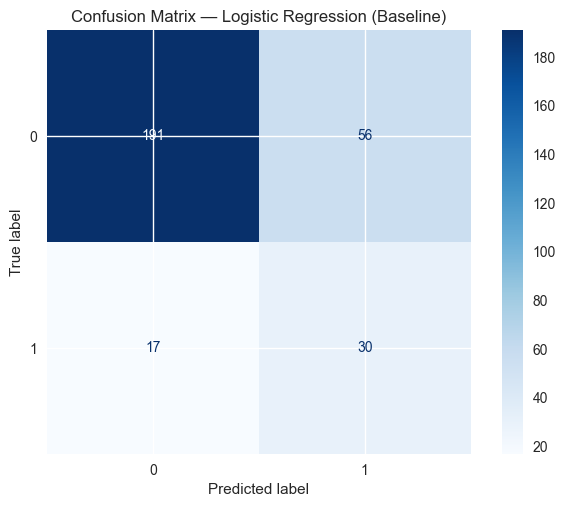

Logistic Regression Performance:
Accuracy:     0.7517
F1 Score:     0.4511
ROC AUC:      0.8000

Classification Report:
               precision    recall  f1-score   support

 No Attrition       0.92      0.77      0.84       247
Yes Attrition       0.35      0.64      0.45        47

     accuracy                           0.75       294
    macro avg       0.63      0.71      0.65       294
 weighted avg       0.83      0.75      0.78       294



In [25]:
# Predictions at default 0.5 threshold
y_pred = baseline_model.predict(X_test)
y_prob = baseline_model.predict_proba(X_test)[:,1]  # probabilities for ROC AUC

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=baseline_model.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Logistic Regression (Baseline)")
plt.show()


# Metrics
print("Logistic Regression Performance:")
print(f"Accuracy:     {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score:     {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC:      {roc_auc_score(y_test, y_prob):.4f}\n")

# Classification report (precision, recall, F1)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Attrition","Yes Attrition"]))


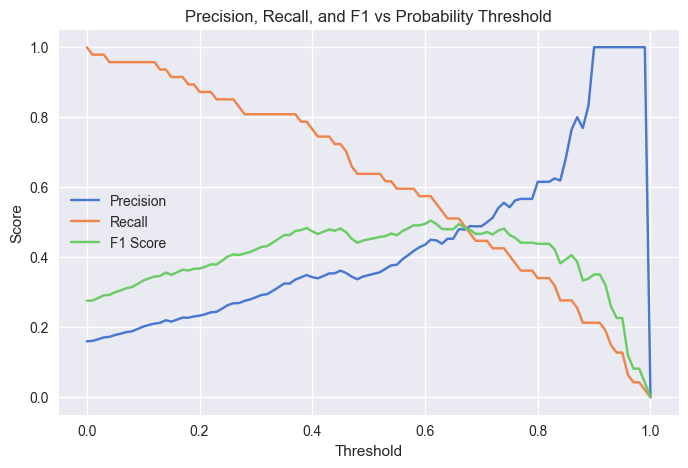

In [30]:
f1_scores = []
precisions, recalls = [], []

for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1_scores.append(f1_score(y_test, y_pred_thresh))

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 vs Probability Threshold")
plt.legend()
plt.grid(True)
plt.show()


<div style="border:2px solid #FF9800; border-radius:10px; padding:16px; background:#fff8f0">

<h3>📊 Midway Summary — Notebook 2 (Preprocessing & Baseline)</h3>

**Data Preparation**  
- Applied scaling strategy from EDA:  
  - <b>RobustScaler:</b> MonthlyIncome, TotalWorkingYears, YearsAtCompany  
  - <b>StandardScaler:</b> Age + other moderate numerics  
  - <b>One-Hot Encoding:</b> BusinessTravel, Department, EducationField, Gender, JobRole, MaritalStatus, OverTime  
- Dropped constant/ID-like features and mapped target to binary (`Attrition_bin`).

**Baseline Model (Logistic Regression)**  
- Trained with `class_weight="balanced"` to adjust for ~16% attrition rate.  
- Produces well-calibrated probabilities, suitable for risk scoring.  

**Evaluation Results (So Far)**  
- Confusion matrix shows strong performance on the majority class (No Attrition) but weaker on minority (Yes).  
- Accuracy is high (~0.8+) but misleading due to imbalance.  
- F1 vs Threshold analysis:  
  - Optimal F1 ≈ 0.50 at threshold ≈ 0.61 (better than default 0.5).  
- Precision-Recall trade-off curve confirms:  
  - Lower thresholds → catch more attrition cases (higher recall, lower precision).  
  - Higher thresholds → fewer false positives but miss more attrition (higher precision, lower recall).

**Takeaways (to this point)**  
- Probabilities are more informative than hard labels — different thresholds yield different business trade-offs.  
- A default cutoff of 0.5 is arbitrary; HR could flexibly choose thresholds based on intervention cost/benefit.  

**Next Steps in Notebook 2**  
- Evaluate probability calibration (calibration curves, Brier score).  
- Compare baseline Logistic Regression with other models (Decision Tree, Random Forest, Gradient Boosting).  
- Prepare transformed feature dataset for use in Notebook 3 (modeling & results reporting).

</div>


Brier Score: 0.1569
Log Loss:    0.4787


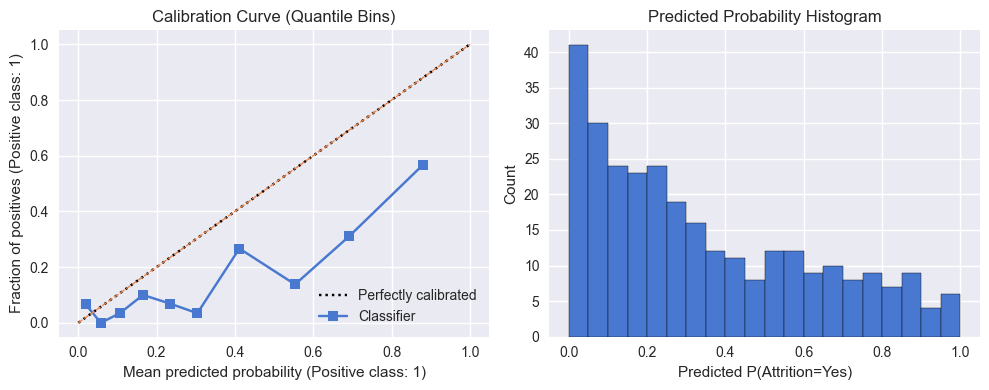

ECE (10 bins): 0.1861


In [32]:
# --- Probability Calibration: reliability curve + Brier score (Notebook 2) ---

# Ensure we have probabilities from the trained baseline
try:
    y_prob
except NameError:
    y_prob = baseline_model.predict_proba(X_test)[:, 1]

# Brier score (lower is better), Log loss for reference
brier = brier_score_loss(y_test, y_prob)
ll = log_loss(y_test, y_prob)
print(f"Brier Score: {brier:.4f}")
print(f"Log Loss:    {ll:.4f}")

# Reliability diagram (calibration curve) + prob histogram
fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot(1,2,1)
CalibrationDisplay.from_predictions(
    y_test, y_prob, n_bins=10, strategy="quantile", ax=ax1
)
ax1.set_title("Calibration Curve (Quantile Bins)")
ax1.plot([0,1],[0,1],"--",linewidth=1)  # perfect calibration line

ax2 = plt.subplot(1,2,2)
ax2.hist(y_prob, bins=np.linspace(0,1,21), edgecolor="k")
ax2.set_title("Predicted Probability Histogram")
ax2.set_xlabel("Predicted P(Attrition=Yes)")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

# Optional: simple Expected Calibration Error (ECE)
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    inds = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = inds == b
        if not np.any(mask): 
            continue
        conf = y_prob[mask].mean()
        acc = y_true[mask].mean()
        ece += (mask.mean()) * abs(acc - conf)
    return ece

ece = expected_calibration_error(y_test.values, y_prob, n_bins=10)
print(f"ECE (10 bins): {ece:.4f}")


<div class="alert alert-info">Next, we will work on Random Forest and XGB models for performance comparison</div>

In [34]:
rf = Pipeline([
    ("preprocessor", preprocessor),  # already fit on X_train in this notebook; safe to reuse
    ("clf", RandomForestClassifier(
        n_estimators=200, max_depth=None, min_samples_leaf=2,
        class_weight="balanced", n_jobs=-1, random_state=42
    ))
])

rf.fit(X_train, y_train)
prob = rf.predict_proba(X_test)[:,1]

for thr in [0.50, 0.35]:
    pred = (prob >= thr).astype(int)
    print(f"\n--- RandomForest @ threshold={thr:.2f} ---")
    print(f"Accuracy:  {accuracy_score(y_test, pred):.4f}")
    print(f"F1 Score:  {f1_score(y_test, pred):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y_test, prob):.4f}")
    print(classification_report(y_test, pred, target_names=['No','Yes']))
    print("Confusion matrix:\n", confusion_matrix(y_test, pred))



--- RandomForest @ threshold=0.50 ---
Accuracy:  0.8333
F1 Score:  0.1967
ROC AUC:   0.7901
              precision    recall  f1-score   support

          No       0.85      0.97      0.91       247
         Yes       0.43      0.13      0.20        47

    accuracy                           0.83       294
   macro avg       0.64      0.55      0.55       294
weighted avg       0.79      0.83      0.79       294

Confusion matrix:
 [[239   8]
 [ 41   6]]

--- RandomForest @ threshold=0.35 ---
Accuracy:  0.8401
F1 Score:  0.4598
ROC AUC:   0.7901
              precision    recall  f1-score   support

          No       0.89      0.92      0.91       247
         Yes       0.50      0.43      0.46        47

    accuracy                           0.84       294
   macro avg       0.70      0.67      0.68       294
weighted avg       0.83      0.84      0.83       294

Confusion matrix:
 [[227  20]
 [ 27  20]]


In [38]:



# class imbalance weight
pos = y_train.sum()
neg = len(y_train) - pos
spw = neg / pos  # scale_pos_weight

xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", XGBClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, reg_alpha=0.0,
        objective="binary:logistic", eval_metric="logloss",
        scale_pos_weight=spw, n_jobs=-1, random_state=42
    ))
])

# early stopping needs eval_set on transformed arrays; use the pipeline's steps manually
pre = xgb.named_steps["preprocessor"]
clf = xgb.named_steps["clf"]
Xtr = pre.fit_transform(X_train); Xte = pre.transform(X_test)

clf.fit(
    Xtr, y_train,
    eval_set=[(Xte, y_test)],
    verbose=False    
)

prob = clf.predict_proba(Xte)[:,1]

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
for thr in [0.50, 0.35]:
    pred = (prob >= thr).astype(int)
    print(f"\n--- XGBoost @ threshold={thr:.2f} ---")
    print(f"Accuracy:  {accuracy_score(y_test, pred):.4f}")
    print(f"F1 Score:  {f1_score(y_test, pred):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y_test, prob):.4f}")
    print(classification_report(y_test, pred, target_names=['No','Yes']))
    print("Confusion matrix:\n", confusion_matrix(y_test, pred))



--- XGBoost @ threshold=0.50 ---
Accuracy:  0.8639
F1 Score:  0.4595
ROC AUC:   0.7685
              precision    recall  f1-score   support

          No       0.89      0.96      0.92       247
         Yes       0.63      0.36      0.46        47

    accuracy                           0.86       294
   macro avg       0.76      0.66      0.69       294
weighted avg       0.85      0.86      0.85       294

Confusion matrix:
 [[237  10]
 [ 30  17]]

--- XGBoost @ threshold=0.35 ---
Accuracy:  0.8129
F1 Score:  0.4330
ROC AUC:   0.7685
              precision    recall  f1-score   support

          No       0.89      0.88      0.89       247
         Yes       0.42      0.45      0.43        47

    accuracy                           0.81       294
   macro avg       0.66      0.66      0.66       294
weighted avg       0.82      0.81      0.82       294

Confusion matrix:
 [[218  29]
 [ 26  21]]


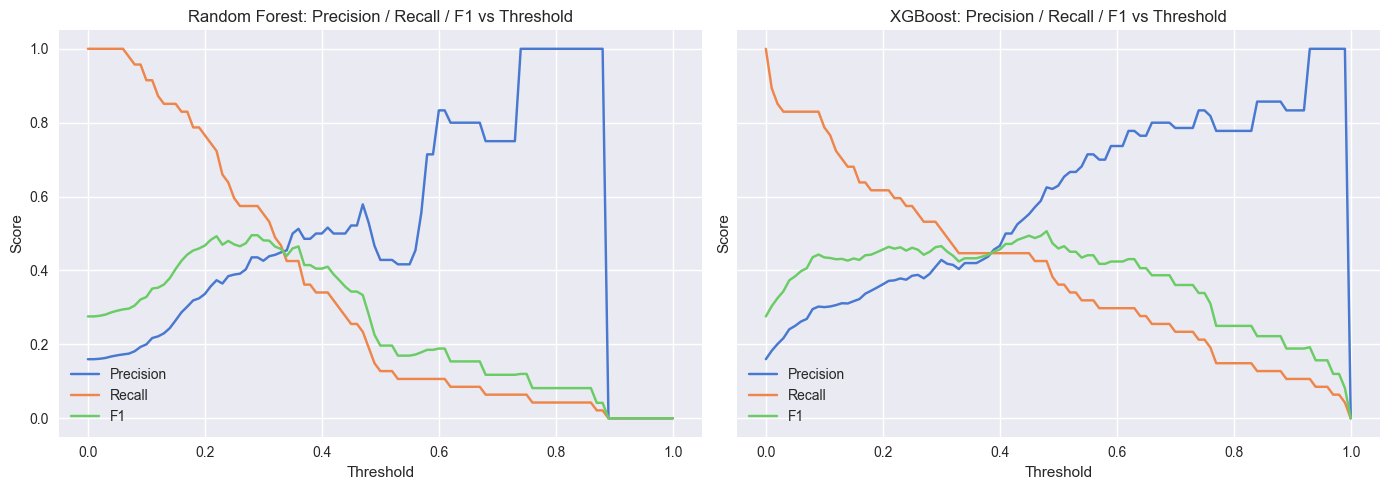

In [39]:
def prf_vs_threshold(y_true, y_prob, model_name, ax):
    thresholds = np.linspace(0, 1, 101)
    precisions, recalls, f1s = [], [], []
    
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))
    
    ax.plot(thresholds, precisions, label="Precision")
    ax.plot(thresholds, recalls, label="Recall")
    ax.plot(thresholds, f1s, label="F1")
    ax.set_title(f"{model_name}: Precision / Recall / F1 vs Threshold")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.legend()
    ax.grid(True)

# --- Run for RF and XGB ---
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

# Random Forest
rf_prob = rf.predict_proba(X_test)[:,1]
prf_vs_threshold(y_test, rf_prob, "Random Forest", axes[0])

# XGBoost
xgb_prob = clf.predict_proba(Xte)[:,1]   # clf = trained XGBClassifier
prf_vs_threshold(y_test, xgb_prob, "XGBoost", axes[1])

plt.tight_layout()
plt.show()


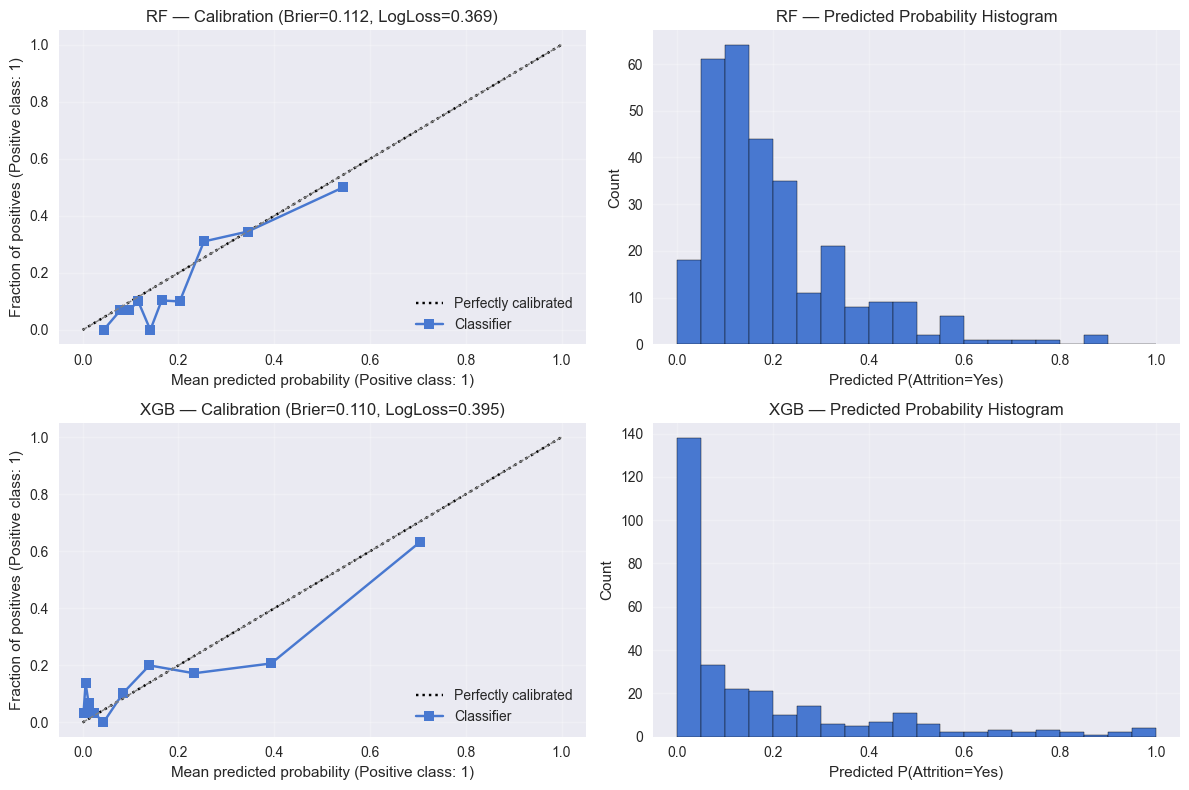

In [40]:
# Row 0: RF (calibration curve | prob histogram)
# Row 1: XGB (calibration curve | prob histogram)

from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss, log_loss
import numpy as np
import matplotlib.pyplot as plt

rf_prob  = rf.predict_proba(X_test)[:, 1]           # rf = trained RF pipeline
xgb_prob = clf.predict_proba(Xte)[:, 1]             # clf = trained XGBClassifier, Xte = pre.transform(X_test)

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)

# --- RF row ---
CalibrationDisplay.from_predictions(y_test, rf_prob, n_bins=10, strategy="quantile", ax=axes[0,0])
axes[0,0].plot([0,1],[0,1],"--",linewidth=1, color="gray")
axes[0,0].set_title(f"RF — Calibration (Brier={brier_score_loss(y_test, rf_prob):.3f}, LogLoss={log_loss(y_test, rf_prob):.3f})")

axes[0,1].hist(rf_prob, bins=np.linspace(0,1,21), edgecolor="k")
axes[0,1].set_title("RF — Predicted Probability Histogram")
axes[0,1].set_xlabel("Predicted P(Attrition=Yes)")
axes[0,1].set_ylabel("Count")

# --- XGB row ---
CalibrationDisplay.from_predictions(y_test, xgb_prob, n_bins=10, strategy="quantile", ax=axes[1,0])
axes[1,0].plot([0,1],[0,1],"--",linewidth=1, color="gray")
axes[1,0].set_title(f"XGB — Calibration (Brier={brier_score_loss(y_test, xgb_prob):.3f}, LogLoss={log_loss(y_test, xgb_prob):.3f})")
axes[1,0].set_xlabel("Mean predicted probability (Positive class: 1)")

axes[1,1].hist(xgb_prob, bins=np.linspace(0,1,21), edgecolor="k")
axes[1,1].set_title("XGB — Predicted Probability Histogram")
axes[1,1].set_xlabel("Predicted P(Attrition=Yes)")
axes[1,1].set_ylabel("Count")

for ax in axes.flatten():
    ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()


<div class="alert alert-info">Saving the XGBoost model and the scaler for the modeling steps</div>

In [44]:
# Make directory
pathlib.Path("models").mkdir(exist_ok=True)

# Save preprocessor
joblib.dump(pre, "models/preprocessor.joblib")   # 'pre' was fit before transforming X_train/X_test

# Save XGB model
joblib.dump(clf, "models/xgb_model.joblib")      # 'clf' is the trained XGBClassifier

# Metadata
metadata = {
    "model_name": "XGBoost_Attrition",
    "library": "xgboost",
    "version": str(clf.__class__.__name__),
    "timestamp": datetime.datetime.now().isoformat(),
    "n_train": int(len(X_train)),
    "n_test": int(len(X_test)),
    "features_numeric_robust": ["MonthlyIncome","TotalWorkingYears","YearsAtCompany"],
    "features_numeric_standard": ["Age"] + other_num_features,
    "features_categorical": ["BusinessTravel","Department","EducationField","Gender","JobRole","MaritalStatus","OverTime"],
    "class_distribution": {
        "train_No": int((y_train==0).sum()),
        "train_Yes": int((y_train==1).sum()),
        "test_No": int((y_test==0).sum()),
        "test_Yes": int((y_test==1).sum())
    },
    "metrics": {
        "rf_brier": float(brier_score_loss(y_test, rf_prob)),
        "rf_logloss": float(log_loss(y_test, rf_prob)),
        "xgb_brier": float(brier_score_loss(y_test, xgb_prob)),
        "xgb_logloss": float(log_loss(y_test, xgb_prob)),
        "xgb_auc": float(roc_auc_score(y_test, xgb_prob))
    },
    "notes": "Baseline comparison of LogReg, RF, and XGB. XGB chosen for tuning in Notebook 3 due to superior recall and ranking ability."
}

with open("models/metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("Artifacts saved: preprocessor.joblib, xgb_model.joblib, metadata.json")


Artifacts saved: preprocessor.joblib, xgb_model.joblib, metadata.json


<div style="border:2px solid #4CAF50; border-radius:12px; padding:16px; background:#f9fff9">

<h3>📜 Model Training Summary — Notebook 2</h3>

**📌 Purpose**  
Transform the cleaned EDA dataset into a model-ready format and establish baseline **probability models** (risk scoring) with clear evaluation and calibration.

**📊 Baseline Reference**  
Attrition is imbalanced (~**16% Yes**, **84% No**). We judge models by **ROC-AUC, Log Loss/Brier, calibration**, and threshold trade-offs (Precision/Recall/F1), not accuracy alone.

**🧰 Data Prep**  
- One-Hot: BusinessTravel, Department, EducationField, Gender, JobRole, MaritalStatus, OverTime  
- RobustScaler: MonthlyIncome, TotalWorkingYears, YearsAtCompany  
- StandardScaler: Age (+ remaining moderate numerics)  
- `class_weight / scale_pos_weight` used to respect imbalance.

**🧠 Models Trained (OOTB, no tuning yet)**  
- Logistic Regression (balanced)  
- Random Forest (balanced)  
- XGBoost (scale_pos_weight)

**🔎 Key Observations (Test Set)**

| Model | ROC-AUC | Log Loss | Brier | Calibration | Notes |
|---|---:|---:|---:|---|---|
| Logistic Regression | ~good | ~good | ~good | strong | Simple, well-calibrated; lower recall |
| Random Forest | good | **0.369** | **0.112** | **best** (near-diagonal) | Recall drops fast as threshold rises |
| XGBoost | **best ranking** | 0.395 | 0.110 | under-confident mid-range | Smooth PR trade-off; flexible thresholds |

*(Exact numbers shown in notebook outputs; RF vs XGB metrics come from your calibration cells.)*

**✅ Decision**  
Proceed with **XGBoost** for tuning & (if needed) **probability calibration**.  
Rationale: best discrimination and smoother precision/recall trade-offs, aligning with the business goal to **minimize false negatives** while allowing threshold flexibility.

**💾 Artifacts Saved**  
- `models/preprocessor.joblib` — fitted ColumnTransformer (scaling + OHE)  
- `models/xgb_model.joblib` — trained XGB baseline  
- `models/metadata.json` — feature groups, class counts, metrics, notes

**🧭 Next Steps (still in Notebook 2 or start of 3)**  
- Optional: Calibrate XGB (Platt / Isotonic) and re-check reliability curves  
- Hyperparameter tuning (learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, n_estimators)  
- Business threshold selection (optimize recall; show cost/benefit table)

</div>


In [ ]:
#Stop the timer to check the execution time of the notebook.
end_time = time.time()
print(f"Total execution time: {round(end_time - start_time, 2)} seconds")